# Chapter 17

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
nhefs_all = pd.read_excel('NHEFS.xls')

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [5]:
for col in ['age', 'wt71', 'smokeintensity', 'smokeyrs']:
    nhefs_all['{}^2'.format(col)] = nhefs_all[col] * nhefs_all[col]

In [6]:
nhefs_all['one'] = 1

In [7]:
edu_dummies = pd.get_dummies(nhefs_all.education, prefix='edu')
exercise_dummies = pd.get_dummies(nhefs_all.exercise, prefix='exercise')
active_dummies = pd.get_dummies(nhefs_all.active, prefix='active')

nhefs_all = pd.concat(
    [nhefs_all, edu_dummies, exercise_dummies, active_dummies],
    axis=1
)

In [8]:
nhefs_all.shape

(1629, 80)

## Section 17.1

Check the number that died during follow-up

In [9]:
death = nhefs_all.death
print("      # died: {:>4}".format(death.sum()))
print("# didn't die: {:>4}".format((1 - nhefs_all.death).sum()))

      # died:  318
# didn't die: 1311


Check the number of deaths for untreated and treated

In [10]:
nhefs_all.groupby('qsmk').agg({'death': 'sum'}).T

qsmk,0,1
death,216,102


Check the first and last dates of recorded death

In [11]:
date_death = 10000 * nhefs_all.yrdth + 100 * nhefs_all.modth + nhefs_all.dadth
date_death = pd.to_datetime(date_death, format="%y%m%d")
print("first death: {}".format(date_death.min().strftime("%b %d, %Y")))
print(" last death: {}".format(date_death.max().strftime("%b %d, %Y")))

first death: Jan 08, 1983
 last death: Dec 12, 1992


Note this means that at least one person died in the last month of the study, month 120.

#### Program 17.1

Add `longevity` and `survived` to the data set

The `longevity` will be the number of months of follow-up lived until death. If the individual did not die, the value is set to 121, the number of follow-up months plus 1. This is different from the book, which uses 120. Using 121 might be unorthodox, but this allows me to more easily differentiate someone who died in month 120 vs someone who didn't have a recorded death.

In [12]:
nhefs_all['longevity'] = (nhefs_all.yrdth - 83) * 12 + nhefs_all.modth
nhefs_all.longevity.replace(np.NaN, 121, inplace=True)

In [13]:
nhefs_all['survived'] = 1 - nhefs_all.death

Percent of survived for untreated and treated

In [14]:
nhefs_all.groupby('qsmk').agg(
    {'survived': lambda col: '{:>0.1f}%'.format(100 * col.mean())}
).T

qsmk,0,1
survived,82.0%,76.2%


Log-rank test: "a common statistical test to compare survival curves", pg 211 margin

In [15]:
chisq, pvalue = sm.duration.survdiff(
    nhefs_all.longevity,
    nhefs_all.death,
    nhefs_all.qsmk
)

print('log-rank test p-value: {:>0.3f}'.format(pvalue))

log-rank test p-value: 0.005


#### Survival curve plot

Figure 17.1

This plot is constructed by iterating through months and measuring the fraction of longevity values greater than that month. Those fraction values are the survival curve values.

We'll start at zero months, where survival is guaranteed to be 100%. (And since survival at zero months is guaranteed to be 100% we could also start at month 1 without loss of information.) For the two treatment values, the values will end at the last month with a recorded death.

In [16]:
longevity0 = nhefs_all.longevity.loc[nhefs_all.qsmk == 0]
longevity1 = nhefs_all.longevity.loc[nhefs_all.qsmk == 1]

In [17]:
# non-quitters
max0 = int(longevity0[longevity0 <= 120].max())  # max longevity for non-quitters
surv_curve_0 = [
    (longevity0 > i).sum() / longevity0.shape[0]  # fraction of longevities greather than current month i
    for i in range(max0 + 1)
]

# quitters
max1 = int(longevity1[longevity1 <= 120].max())  # max longevity for quitters
surv_curve_1 = [
    (longevity1 > i).sum() / longevity1.shape[0]  # fraction of longevities greather than current month i
    for i in range(max1 + 1)
]

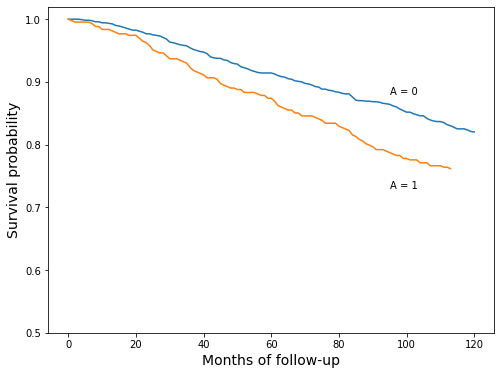

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(surv_curve_0)
ax.plot(surv_curve_1)
ax.set_ylim(0.5, 1.02)
ax.set_xlabel('Months of follow-up', fontsize=14)
ax.set_ylabel('Survival probability', fontsize=14)
ax.text(95, 0.88, 'A = 0')
ax.text(95, 0.73, 'A = 1');

Hazard at 120 months for treated

In [19]:
numer = (longevity1 == 120).sum()
denom = (longevity1 > 119).sum()
print('{}/{} = {:>0.2f}%'.format(numer, denom, numer * 100.0 / denom))

0/326 = 0.00%


Hazard at 120 months for untreated

In [20]:
numer = (longevity0 == 120).sum()
denom = (longevity0 > 119).sum()
print('{}/{} = {:>0.2f}%'.format(numer, denom, numer * 100.0 / denom))

1/986 = 0.10%


The book has another description of how to calculate survival on pg 212:

$$
\text{Pr}[D_k = 0] = \prod_{m=1}^k \text{Pr}[D_m  =0 | D_{m-1} = 0]
$$

"That is, the survival at $k$ equals the product of one minus the hazard at all previous times."

And hazard at $k$ can be estimated "by dividing the number of cases during the interval $k$ by the number of individuals alive at the end of interval $k-1$."

I'll show that using this description of survival gives (roughly) the same values for `qsmk` = 0.

In [21]:
hazard0 = [
    (longevity0 == i).sum() / (longevity0 >= i - 1).sum()
    for i in range(max0 + 1)
]

Survival curves will be calculated from hazard values multiple times throughout the notebook, so I'll make a function

In [22]:
def survival_curve(hazard):
    survival = [1 - hazard[0]]
    for i in range(1, len(hazard)):
        survival.append((1 - hazard[i]) * survival[i - 1])
    return survival

In [23]:
survival0_v2 = survival_curve(hazard0)

In [24]:
surv_curve_0[:6]

[1.0, 1.0, 1.0, 1.0, 0.9991673605328892, 0.9983347210657785]

In [25]:
survival0_v2[:6]

[1.0, 1.0, 1.0, 1.0, 0.9991673605328892, 0.9983354143542607]

In [26]:
max_diff = np.abs([a - b for a, b in zip(surv_curve_0, survival0_v2)]).max()
print("maximum difference between methods: {:>0.2e}".format(max_diff))

maximum difference between methods: 2.89e-04


This difference is likely due to a propagation of rounding errors, and probably wouldn't be visible on the plot

## Section 17.2

#### Program 17.2

Create the person-time format

The following function will be used throughout this notebook to create the person-time format

In [27]:
def person_time_format(data):
    # This works for the current data only; it requires the data
    # have `longevity` and `death` columns.

    # accumulate rows in a dict, then convert the dict to DataFrame;
    # the dict will contain each column of the input data, plus
    # `time`, which keeps track of month within individual, and
    # `event`, a 0/1 indicator of death for each month
    newrows = {name: [] for name in data.columns}
    newrows.update({'time': [], 'event': []})
    
    for _, row in data.iterrows():
        # number of rows per subject, i.e., number of months in the study
        n_mos = min(int(row.longevity), 120)
        for name in data.columns:
            newrows[name].extend([row[name]] * n_mos)
        newrows['time'].extend(range(n_mos))
        newrows['event'].extend([0] * n_mos)
        if row.death:
            newrows['event'][-1] = 1

    return pd.DataFrame(newrows)

In [28]:
pt_data = person_time_format(nhefs_all)

In [29]:
pt_data.shape

(176764, 84)

"An easy way to parametrically estimate the hazards is to fit a logistic regression model ...", pg 213

In [30]:
model = sm.Logit.from_formula(
    'event ~ qsmk + qsmk:time + qsmk:np.power(time, 2) + time + np.power(time, 2)',
    data=pt_data
)
res = model.fit()

Optimization terminated successfully.
         Current function value: 0.013100
         Iterations 11


In [31]:
res.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-6.9956,0.231,-30.291,0.000,-7.448,-6.543
qsmk,0.3355,0.397,0.845,0.398,-0.443,1.114
qsmk:time,0.0121,0.015,0.804,0.422,-0.017,0.042
"qsmk:np.power(time, 2)",-0.0002,0.000,-1.293,0.196,-0.000,8.31e-05
time,0.0196,0.008,2.329,0.020,0.003,0.036
"np.power(time, 2)",-0.0001,6.69e-05,-1.878,0.060,-0.000,5.47e-06


Create predictions for each time point, for both `qsmk == 0` and `qsmk == 1`

In [32]:
A0_pred = res.predict(
    pd.DataFrame({'time': list(range(120)), 'qsmk': [0] * 120})
)
A1_pred = res.predict(
    pd.DataFrame({'time': list(range(120)), 'qsmk': [1] * 120})
)

Just a quick look at the values of `A0_pred`

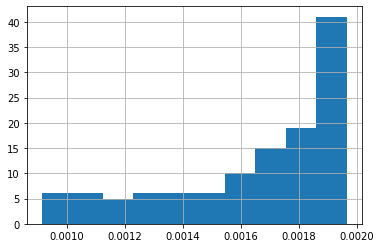

In [33]:
A0_pred.hist();

Create the model-based survival curves, and recreate Figure 17.4

The `survival_curve` function below was defined in cell 22 above. For explanation, see the text between cells 20 and 21.

In [34]:
model_surv_0 = survival_curve(A0_pred)
model_surv_1 = survival_curve(A1_pred)

Figure 17.4

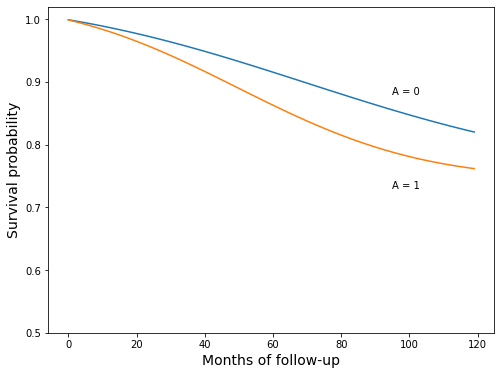

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(model_surv_0)
ax.plot(model_surv_1)
ax.set_ylim(0.5, 1.02)
ax.set_xlabel('Months of follow-up', fontsize=14)
ax.set_ylabel('Survival probability', fontsize=14)
ax.text(95, 0.88, 'A = 0')
ax.text(95, 0.73, 'A = 1');

"These curves are a smooth version of those in Figure 17.1", pg 213

Plot the new parametric version and the previous nonparametric version together, just to see how well they line up

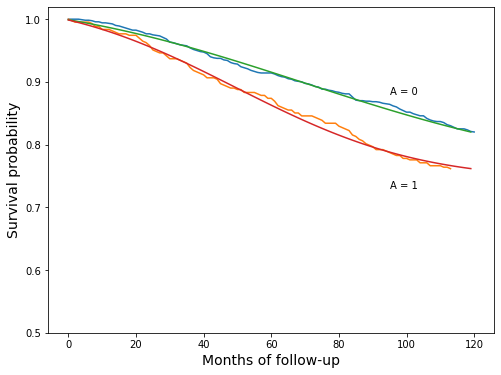

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(surv_curve_0)
ax.plot(surv_curve_1)

ax.plot(model_surv_0)
ax.plot(model_surv_1)

ax.set_ylim(0.5, 1.02)
ax.set_xlabel('Months of follow-up', fontsize=14)
ax.set_ylabel('Survival probability', fontsize=14)
ax.text(95, 0.88, 'A = 0')
ax.text(95, 0.73, 'A = 1');

## Section 17.4

#### Program 17.3

"The estimation of IP weighted survival curves has two steps"

"First, we estimate the stabilized IP weights $SW^A$", pg 217

We'll once again borrow a function from Chapter 12 to create IP weights

In [37]:
def logit_ip_weights(y, X):
    """
    Create IP weights from logistic regression
    
    Parameters
    ----------
    y : Pandas Series
    X : Pandas DataFrame
    
    Returns
    -------
    Numpy array of IP weights
    
    """
    model = sm.Logit(y, X)
    res = model.fit()
    weights = np.zeros(X.shape[0])
    weights[y == 1] = res.predict(X.loc[y == 1])
    weights[y == 0] = 1 - res.predict(X.loc[y == 0])
    return weights

In [38]:
X = nhefs_all[[
    'one', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2',
    'age', 'age^2', 'wt71', 'wt71^2',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2'
]]

In [39]:
ip_denom = logit_ip_weights(nhefs_all.qsmk, X)

Optimization terminated successfully.
         Current function value: 0.542264
         Iterations 6


In [40]:
pr_qsmk = nhefs_all.qsmk.mean()

ip_numer = np.zeros(ip_denom.shape[0])
ip_numer[nhefs_all.qsmk == 0] = 1 - pr_qsmk
ip_numer[nhefs_all.qsmk == 1] = pr_qsmk

In [41]:
ip_weights = ip_numer / ip_denom

In [42]:
print('Stabilized weights')
print(' min   mean    max')
print('------------------')
print('{:>04.2f}   {:>04.2f}   {:>04.2f}'.format(
    ip_weights.min(),
    ip_weights.mean(),
    ip_weights.max()
))

Stabilized weights
 min   mean    max
------------------
0.33   1.00   4.21


"Second, using the person-time format, we fit a harzards model like the one described in Section 17.2, except that individuals are weighted by their estimated $SW^A$", pg 217

So, recreate the person-time dataset, but with weights, and fit the model. We can create the person-time format by adding the IP weights to the dataset, and using the function `person_time_format` from above. Since that function expands every column into the person-time format, it'll handle the weights too.

In [43]:
nhefs_all['weight'] = ip_weights

In [44]:
pt_data = person_time_format(nhefs_all)

In [45]:
model = sm.GLM.from_formula(
    'event ~ qsmk + qsmk:time + qsmk:np.power(time, 2) + time + np.power(time, 2)',
    freq_weights=pt_data.weight,
    family=sm.families.Binomial(),
    data=pt_data
)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  event   No. Observations:               176764
Model:                            GLM   Df Residuals:                176922.33
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2313.1
Date:                Fri, 07 Jan 2022   Deviance:                       4626.2
Time:                        13:35:41   Pearson chi2:                 1.76e+05
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -6.8970      0.221    -31.241      0.000      -7.330      -6.464
qsmk                      -0.1794      0.440     -0.408      0.683      -1.042       0.683
qsmk:time                  0.0189      0.016      1.155      0.248      -0.013       0.051
qsmk:np.power(time, 2)    -0.0002      0.000     -1.556      0.120      -0.000    5.47e-05
time                       0.0189      0.008      2.345      0.019       0.003       0.035
np.power(time, 2)         -0.0001    6.4e-05     -1.846      0.065      -0.000    7.31e-06
==========================================================================================
"""

Plotting the curves is the same as last plot

In [46]:
A0_pred = res.predict(
    pd.DataFrame({'time': list(range(120)), 'qsmk': [0] * 120})
)
A1_pred = res.predict(
    pd.DataFrame({'time': list(range(120)), 'qsmk': [1] * 120})
)

The `survival_curve` function below was defined in cell 22 above. For explanation, see the text between cells 20 and 21.

In [47]:
surv_ip_0 = survival_curve(A0_pred)
surv_ip_1 = survival_curve(A1_pred)

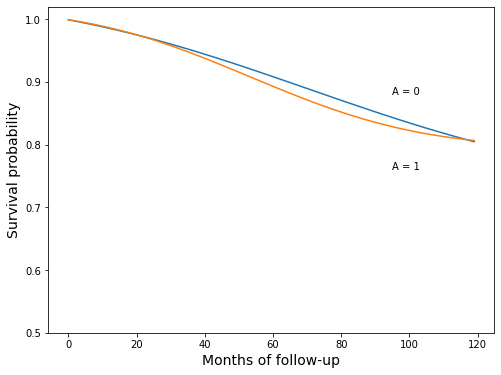

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(surv_ip_0)
ax.plot(surv_ip_1)
ax.set_ylim(0.5, 1.02)
ax.set_xlabel('Months of follow-up', fontsize=14)
ax.set_ylabel('Survival probability', fontsize=14)
ax.text(95, 0.88, 'A = 0')
ax.text(95, 0.76, 'A = 1');

Plot the curves on top of the curves from the previous model, to see how they've changed

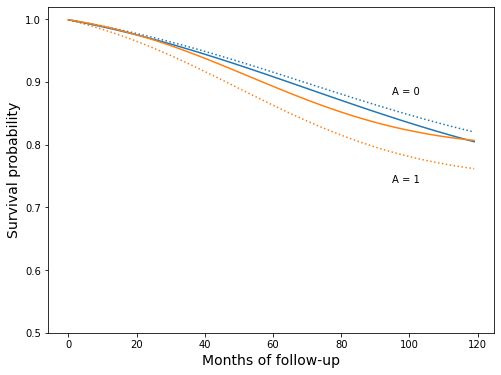

In [49]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(model_surv_0, linestyle=":", c="C0")
ax.plot(model_surv_1, linestyle=":", c="C1")

ax.plot(surv_ip_0, c="C0")
ax.plot(surv_ip_1, c="C1")

ax.set_ylim(0.5, 1.02)
ax.set_xlabel('Months of follow-up', fontsize=14)
ax.set_ylabel('Survival probability', fontsize=14)
ax.text(95, 0.88, 'A = 0')
ax.text(95, 0.74, 'A = 1');

In [50]:
print('survival estimates')
print('     smoking cessation: {:>0.1f}%'.format(surv_ip_1[-1] * 100))
print('  no smoking cessation: {:>0.1f}%'.format(surv_ip_0[-1] * 100))

survival estimates
     smoking cessation: 80.7%
  no smoking cessation: 80.5%


#### Create 500 boostrap samples to get confidence intervals

In [51]:
def model_results(boot_data):
    model = sm.GLM.from_formula(
        'event ~ qsmk + qsmk:time + qsmk:np.power(time, 2) + time + np.power(time, 2)',
        freq_weights=boot_data.weight,
        family=sm.families.Binomial(),
        data=boot_data
    )
    results = model.fit()
    return results

In [52]:
def month_preds(results):
    A0_pred = results.predict(
        pd.DataFrame({'time': list(range(120)), 'qsmk': [0] * 120})
    )
    A1_pred = results.predict(
        pd.DataFrame({'time': list(range(120)), 'qsmk': [1] * 120})
    )
    return A0_pred, A1_pred

In [53]:
def survival_difference(boot_data):
    results = model_results(boot_data)
    A0_pred, A1_pred = month_preds(results)
    surv_ip_0 = survival_curve(A0_pred)
    surv_ip_1 = survival_curve(A1_pred)
    min_diff = min(s1 - s0 for s1, s0 in zip(surv_ip_1, surv_ip_0))
    end_diff = surv_ip_1[-1] - surv_ip_0[-1]
    return min_diff, end_diff

The next cell will take a while to run

In [54]:
min_diff_samples = []
end_diff_samples = []
nrows = pt_data.shape[0]
for i in tqdm(range(500)):
    boot_data = pt_data.sample(nrows, replace=True, axis=0)
    min_diff, end_diff = survival_difference(boot_data)
    min_diff_samples.append(min_diff)
    end_diff_samples.append(end_diff)

100%|██████████| 500/500 [07:20<00:00,  1.14it/s]


In [55]:
estimate = (surv_ip_1[-1] - surv_ip_0[-1]) * 100
ci_lo, ci_hi = np.percentile(end_diff_samples, q=[2.5, 97.5]) * 100

print('difference in final survival probability')
print('  est   CI')
print(' {:>0.1f}%   ({:>0.1f}, {:>0.1f})'.format(estimate, ci_lo, ci_hi))

difference in final survival probability
  est   CI
 0.2%   (-4.2, 4.6)


In [56]:
estimate = min(s1 - s0 for s1, s0 in zip(surv_ip_1, surv_ip_0)) * 100
ci_lo, ci_hi = np.percentile(min_diff_samples, q=[2.5, 97.5]) * 100

print('largest difference in survival probability')
print('   est   CI')
print(' {:>0.1f}%   ({:>0.1f}, {:>0.1f})'.format(estimate, ci_lo, ci_hi))

largest difference in survival probability
   est   CI
 -1.9%   (-6.1, 0.1)


The previous two confidence intervals differ from the book's, but they also change from run to run

## Section 17.5

### Program 17.4

The steps will be similar to Program 13.3, with calculation of survival curves similar to the previous program. However, survival curves will be estimated for each individual, and the final curves will be averages of those curves

1. outcome modeling, on the original data (aka "block 1")
2. prediction on expanded dataset _per individual_, see below)
    - block 2: a copy of the dataset with `qsmk` set to zero
    - block 3: a copy of the dataset with `qsmk` set to one
3. create the survival curves from the predictions, _per individual_, see below
4. average the individual curves to get marginal survival curves

Step 1

In [57]:
model = sm.GLM.from_formula(
    'event ~ qsmk + qsmk:time + qsmk:I(time ** 2) + time + I(time ** 2) + sex'
    '+ race + age + I(age**2) + C(education) + smokeintensity + I(smokeintensity ** 2)'
    '+ smokeyrs + I(smokeyrs ** 2) + C(exercise) + C(active) + wt71 + I(wt71 ** 2)'
    '+ smkintensity82_71',
    family=sm.families.Binomial(),
    data=pt_data
)
res = model.fit()

In [58]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  event   No. Observations:               176764
Model:                            GLM   Df Residuals:                   176739
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2092.9
Date:                Fri, 07 Jan 2022   Deviance:                       4185.7
Time:                        13:43:06   Pearson chi2:                 1.74e+05
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -9.2724      1.379     -6.723      0.000     -11.976      -6.569
C(education)[T.2.0]       -0.1401      0.157     -0.895      0.371      -0.447       0.167
C(education)[T.3.0]       -0.4335      0.153     -2.841      0.005      -0.733      -0.134
C(education)[T.4.0]       -0.2350      0.279     -0.842      0.400      -0.782       0.312
C(education)[T.5.0]       -0.3750      0.239     -1.571      0.116      -0.843       0.093
C(exercise)[T.1.0]        -0.1469      0.179     -0.820      0.412      -0.498       0.204
C(exercise)[T.2.0]         0.1504      0.176      0.854      0.393      -0.195       0.496
C(active)[T.1.0]           0.1601      0.130      1.232      0.218      -0.095       0.415
C(active)[T.2.0]           0.2294      0.188      1.222      0.222      -0.139       0.597
qsmk                      -0.0596      0.415     -0.143      0.886      -0.874       0.755
qsmk:time                  0.0149      0.015      0.987      0.324      -0.015       0.044
qsmk:I(time ** 2)         -0.0002      0.000     -1.367      0.172      -0.000    7.39e-05
time                       0.0227      0.008      2.690      0.007       0.006       0.039
I(time ** 2)              -0.0001   6.71e-05     -1.750      0.080      -0.000    1.41e-05
sex                       -0.4368      0.141     -3.101      0.002      -0.713      -0.161
race                       0.0524      0.173      0.302      0.763      -0.288       0.392
age                        0.0875      0.059      1.481      0.139      -0.028       0.203
I(age ** 2)            -8.128e-05      0.001     -0.149      0.882      -0.001       0.001
smokeintensity             0.0016      0.014      0.114      0.909      -0.026       0.030
I(smokeintensity ** 2)  7.182e-05      0.000      0.301      0.764      -0.000       0.001
smokeyrs                   0.0168      0.031      0.547      0.584      -0.043       0.077
I(smokeyrs ** 2)         5.28e-05      0.000      0.124      0.901      -0.001       0.001
wt71                      -0.0622      0.019     -3.270      0.001      -0.100      -0.025
I(wt71 ** 2)               0.0004      0.000      3.584      0.000       0.000       0.001
smkintensity82_71          0.0017      0.007      0.259      0.795      -0.011       0.014
==========================================================================================
"""

Steps 2 & 3

The model gives the information for constructing _conditional_ survival curves.

As the text says, "we can use this model to estimate the survival curves under treatment and no treatment for white men aged 61, with college education, low levels of exercise, etc. However, our goal is estimating the marginal, not the conditional", pg 218

To get the marginal survival curves, we create conditional curves and average them. To do this, we create a full person-time set for each individual twice, once with `qsmk` equal to zero, and once with `qsmk` equal to one. Then we'll create the survival curves for each individual, and average by time.

To create the individual person-time sets, we'll go row-by-row through the original data, set `death` to zero and `longevity` to 120, i.e. survived through end of follow-up, and set `qsmk` to zero or one.

We'll use two arrays to carry all of the survival curves, fill it in for each individual, then average the array.

In [59]:
survivals_qsmk0 = np.zeros((nhefs_all.shape[0], 120))
survivals_qsmk1 = np.zeros((nhefs_all.shape[0], 120))

The `survival_curve` function below was defined in cell 22 above. For explanation, see the text between cells 20 and 21.

In [60]:
# fill in the individual survival curves
for i, (_, row) in enumerate(nhefs_all.iterrows()):
    # the person_time_format function expects a DataFrame, so convert the
    # row to a DataFrame first
    frame = pd.DataFrame([list(row)], columns=row.index)
    frame["death"] = 0
    frame["longevity"] = 120

    # qsmk = 0 curve
    pt_block2_i = person_time_format(frame)
    pt_block2_i["qsmk"] = 0
    hazard = res.predict(pt_block2_i)
    survivals_qsmk0[i] = survival_curve(hazard)

    # qsmk = 1 curve
    pt_block3_i = pt_block2_i.copy()
    pt_block3_i["qsmk"] = 1
    hazard = res.predict(pt_block3_i)
    survivals_qsmk1[i] = survival_curve(hazard)

Step 4: Average the individual curves

In [61]:
surv_gform_0 = survivals_qsmk0.mean(axis=0)
surv_gform_1 = survivals_qsmk1.mean(axis=0)

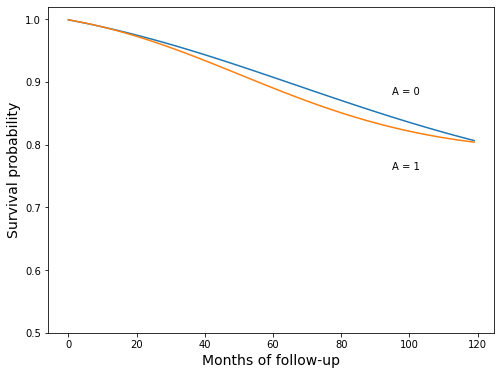

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(surv_gform_0)
ax.plot(surv_gform_1)
ax.set_ylim(0.5, 1.02)
ax.set_xlabel('Months of follow-up', fontsize=14)
ax.set_ylabel('Survival probability', fontsize=14)
ax.text(95, 0.88, 'A = 0')
ax.text(95, 0.76, 'A = 1');

Plot these curves over the previous version, to see how they change

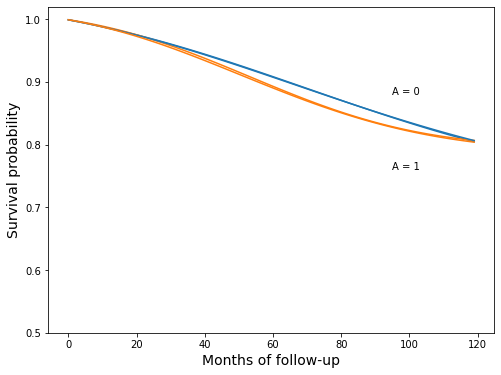

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(surv_ip_0, c="C0")
ax.plot(surv_ip_1, c="C1")

ax.plot(surv_gform_0, c="C0")
ax.plot(surv_gform_1, c="C1")

ax.set_ylim(0.5, 1.02)
ax.set_xlabel('Months of follow-up', fontsize=14)
ax.set_ylabel('Survival probability', fontsize=14)
ax.text(95, 0.88, 'A = 0')
ax.text(95, 0.76, 'A = 1');

Looks like a pretty good match

Now let's look at the mean survival curves plotted over some of the individual curves

100%|██████████| 1629/1629 [00:01<00:00, 1030.11it/s]


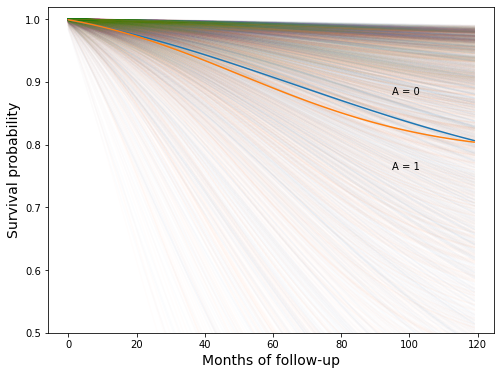

In [64]:
fig, ax = plt.subplots(figsize=(8, 6))

n_subj_tot = nhefs_all.shape[0]
for i in tqdm(range(n_subj_tot)):
    ax.plot(survivals_qsmk0[i], c="C0", alpha=0.01)
    ax.plot(survivals_qsmk1[i], c="C1", alpha=0.01)

ax.plot(surv_gform_0)
ax.plot(surv_gform_1)

ax.set_ylim(0.5, 1.02)
ax.set_xlabel('Months of follow-up', fontsize=14)
ax.set_ylabel('Survival probability', fontsize=14)
ax.text(95, 0.88, 'A = 0')
ax.text(95, 0.76, 'A = 1');

Apparently, there is a _lot_ of variation between individuals